In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from model import min_max_scale, select_kbest, rfe

from acquire import get_zillow_data
# from prepare import prep_zillow

## Acquisition

In [2]:
df = pd.read_csv('zillow.csv', index_col=0)
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,transactiondate,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,2017-01-01,0.025595,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,2017-01-01,0.055619,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,2017-01-01,0.005383,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,2017-01-01,-0.103410,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,2017-01-01,0.006940,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
# what does the initial data look like?
df.shape

(73424, 68)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73424 entries, 0 to 73423
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            73424 non-null  int64  
 1   parcelid                      73424 non-null  int64  
 2   airconditioningtypeid         24546 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   73424 non-null  float64
 6   bedroomcnt                    73424 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         46646 non-null  float64
 9   calculatedbathnbr             73409 non-null  float64
 10  decktypeid                    611 non-null    float64
 11  finishedfloor1squarefeet      5993 non-null   float64
 12  calculatedfinishedsquarefeet  73424 non-null  float64
 13  f

In [5]:
# which columns are missing the most data
#null_counts = df.isnull().sum().sort_values(ascending=False)
#null_counts.head(10)

In [6]:
#null_counts.tail(30)

## Preparation

In [7]:
# add a county column
def fips_labels(x):
    if x['fips'] == 6037:
        return 'Los Angeles County'
    elif x['fips'] == 6059:
        return 'Orange County'
    elif x['fips'] == 6111:
        return 'Ventura County'
    
df['county'] = df.apply(lambda x: fips_labels(x), axis=1)

In [8]:
df = df[df.propertylandusetypeid.isin([260, 261, 263, 264, 266, 270, 273, 274, 275, 279])]

In [9]:
# dropping desciption, id, irrelevant, or redundant columns
df = df.drop(columns=['id', 'roomcnt', 'fips', 'rawcensustractandblock', 
                      'propertycountylandusecode', 'fullbathcnt', 'parcelid',
                      'heatingorsystemtypeid', 'unitcnt', 'buildingqualitytypeid',
                      'propertyzoningdesc','heatingorsystemtypeid', 
                      'heatingorsystemdesc', 'calculatedbathnbr','finishedsquarefeet12',
                      'assessmentyear', 'propertylandusedesc', 'censustractandblock',
                      'regionidcity', 'regionidcounty'])

In [10]:
# drop columns and rows with over 60% values missing
def handle_missing_values(df, prop_required_column = .60, prop_required_row = .60):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [11]:
df = handle_missing_values(df)

In [12]:
#df.isnull().sum().sort_values(ascending=False).head(12)

In [13]:
# Function to split data into train, validate, test datasets
def zillow_split(df):
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=27)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=27)
    return train, validate, test

In [14]:
train, validate, test = zillow_split(df)

In [15]:
# Categorical/Discrete columns to use mode to replace nulls

cols = [
    "regionidzip",
    "yearbuilt"
]

for col in cols:
    mode = int(train[col].mode()) # I had some friction when this returned a float (and there were no decimals anyways)
    train[col].fillna(value=mode, inplace=True)
    validate[col].fillna(value=mode, inplace=True)
    test[col].fillna(value=mode, inplace=True)

In [16]:
#train.isnull().sum().sort_values(ascending=False).head(10)

In [17]:
# Continuous valued columns to use median to replace nulls

cols = [
    "structuretaxvaluedollarcnt",
    "taxamount",
    "taxvaluedollarcnt",
    "landtaxvaluedollarcnt",
    "structuretaxvaluedollarcnt",
    "calculatedfinishedsquarefeet",
    "lotsizesquarefeet"
]


for col in cols:
    median = train[col].median()
    train[col].fillna(median, inplace=True)
    validate[col].fillna(median, inplace=True)
    test[col].fillna(median, inplace=True)

In [18]:
train.isnull().sum().sort_values(ascending=False).sum()

0

In [19]:
train.shape

(39813, 16)

In [20]:
# rename columns for easy reading
cols_to_rename = {
    'regionidzip': 'zipcode',
    'calculatedfinishedsquarefeet': 'sqft',
    'taxvaluedollarcnt': 'home_value',
    'lotsizesquarefeet': 'lot_sqft',
    'propertylandusetypeid': 'property_type',
    'structuretaxvaluedollarcnt': 'structure_value',
    'landtaxvaluedollarcnt': 'land_value'
    ''}
train = train.rename(columns=cols_to_rename)
validate = validate.rename(columns=cols_to_rename)
test = validate.rename(columns=cols_to_rename)

In [21]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertylandusetypeid',
       'regionidzip', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
       'transactiondate', 'logerror', 'county'],
      dtype='object')

In [22]:
train.columns.all() == validate.columns.all() == test.columns.all()

True

In [23]:
cat_vars = [
    "zipcode",
    "yearbuilt",
    "county",
    "property_type"
]

In [24]:
cont_vars = [
    "structure_value",
    "taxamount",
    "home_value",
    "land_value",
    "structure_value",
    "sqft",
    "bathroomcnt",
    "bedroomcnt",
    "lot_sqft",
    "longitude",
    "latitude",
]

## Exploration

Questions
1. does log error vary across counties?
2. is there a relationship beween log error and?
    - home value
    - sqft
    - latitude
    - longitude

In [25]:
train.nunique()

bathroomcnt           19
bedroomcnt            11
sqft                4172
latitude           34510
longitude          33050
lot_sqft           13498
property_type          6
zipcode              385
yearbuilt            127
structure_value    29550
home_value         29310
land_value         29934
taxamount          38867
transactiondate      252
logerror           39655
county                 3
dtype: int64

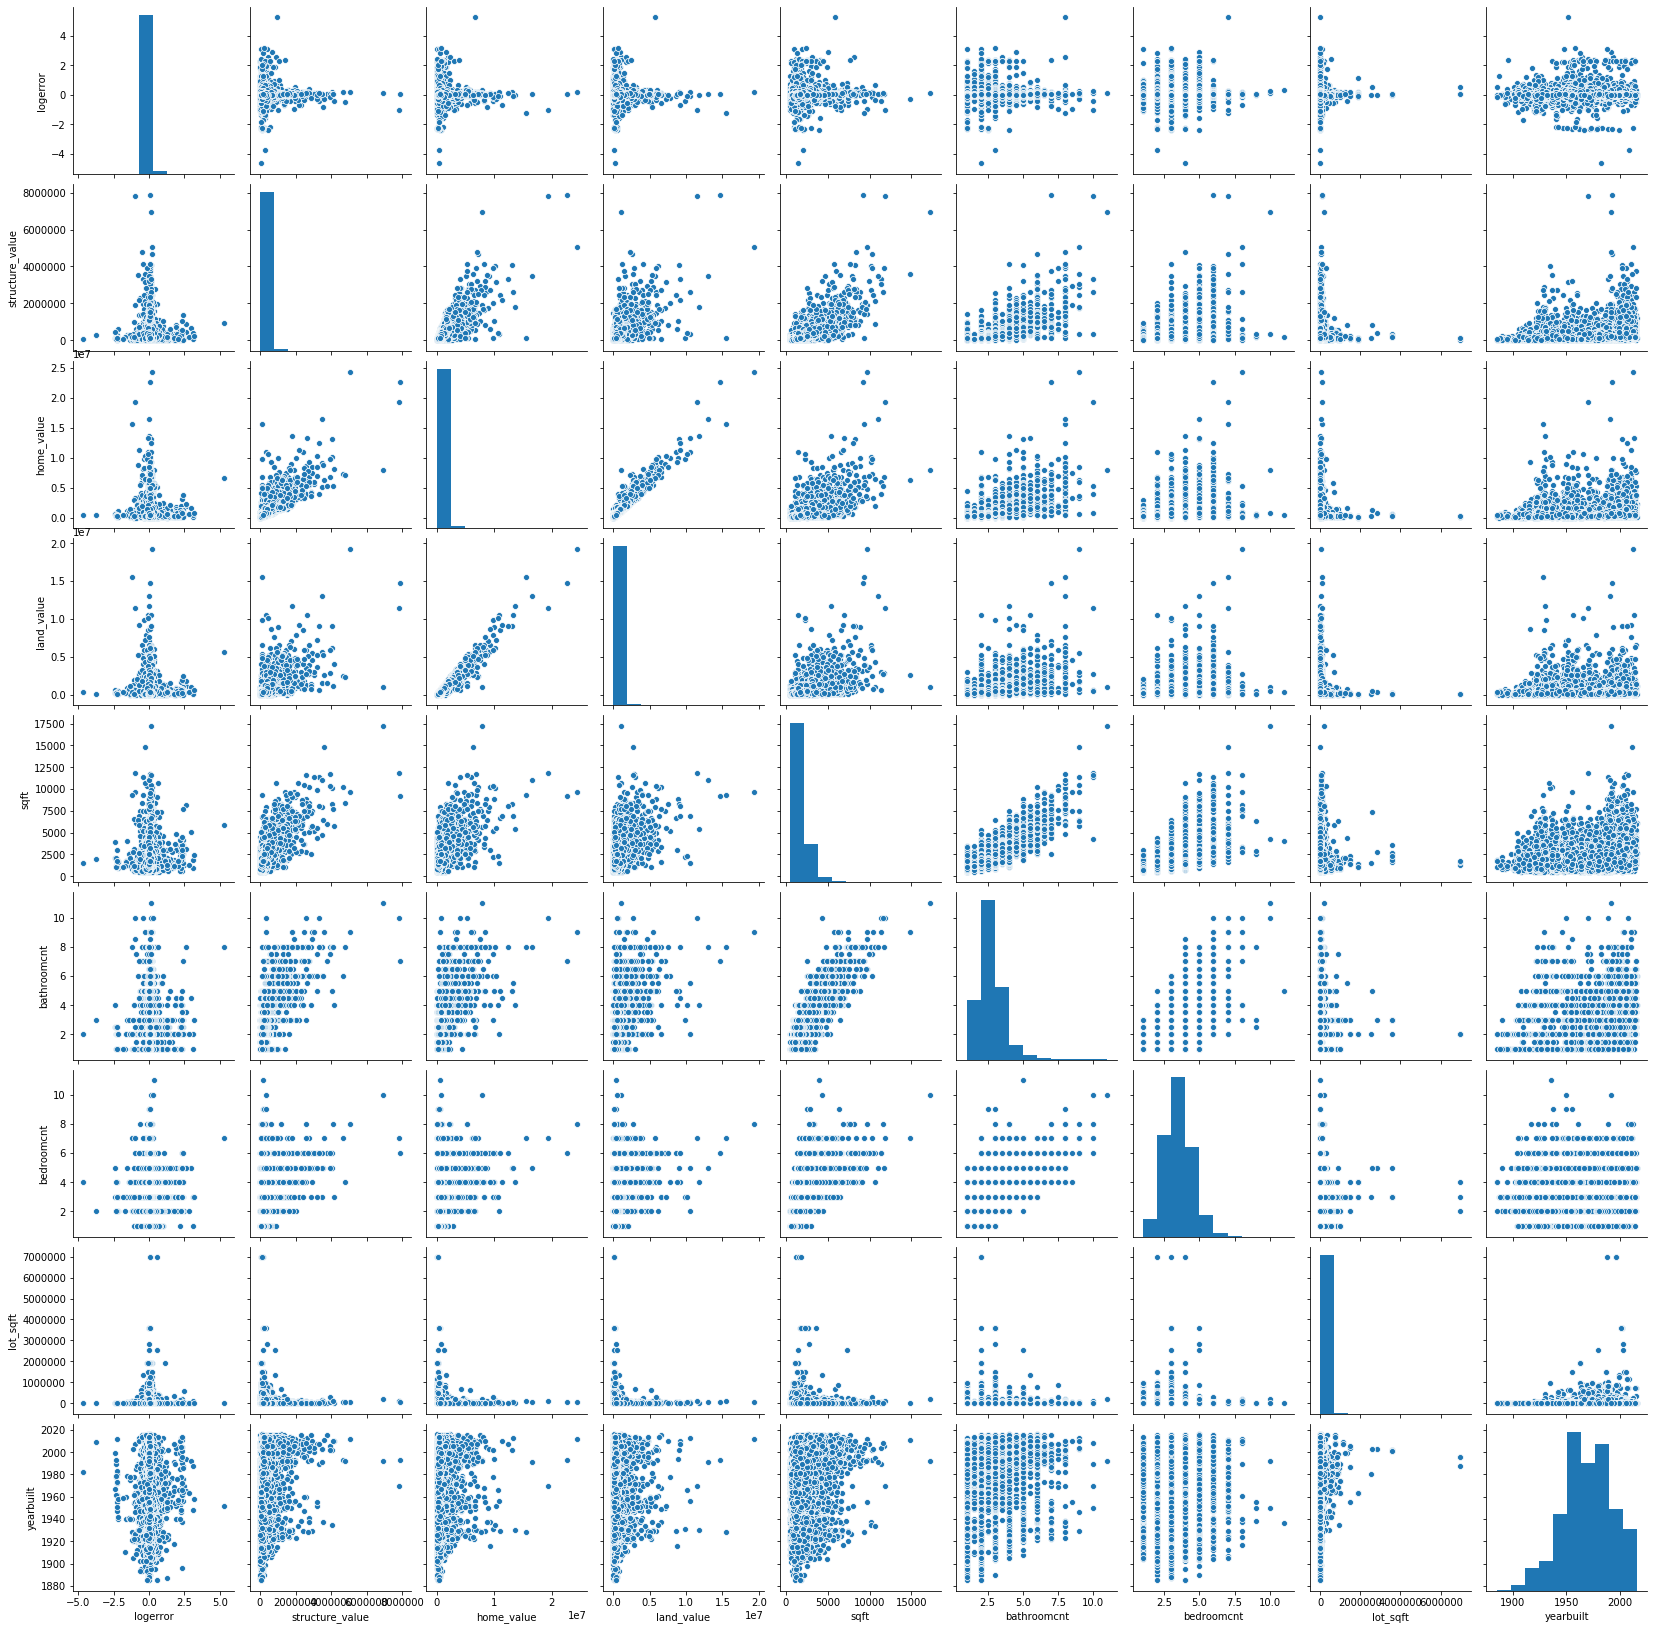

In [26]:
sns.pairplot(train[[
    "logerror", 
    "structure_value",
    "home_value",
    "land_value",
    "sqft",
    "bathroomcnt",
    "bedroomcnt",
    "lot_sqft", "yearbuilt"
]])

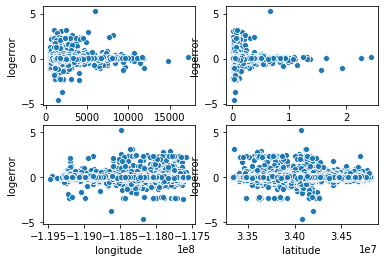

In [27]:
plt.subplot(221)
sns.scatterplot(y=train.logerror, x=train.sqft)

plt.subplot(222)
sns.scatterplot(y=train.logerror, x=train.home_value)

plt.subplot(223)
sns.scatterplot(y=train.logerror, x=train.longitude)

plt.subplot(224)
sns.scatterplot(y=train.logerror, x=train.latitude)

Text(0.5, 1.0, 'Is there a difference in Log Error for each County?')

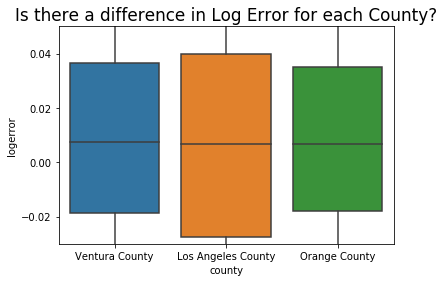

In [28]:
sns.boxplot(x=train.county, y=train.logerror)
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=14)
plt.ylim(-.03, .05)
plt.title('Is there a difference in Log Error for each County?')

### Hypothesis Tests

Text(0.5, 1, 'Is the mean logerror significantly greater in Orange County vs all three counties?')

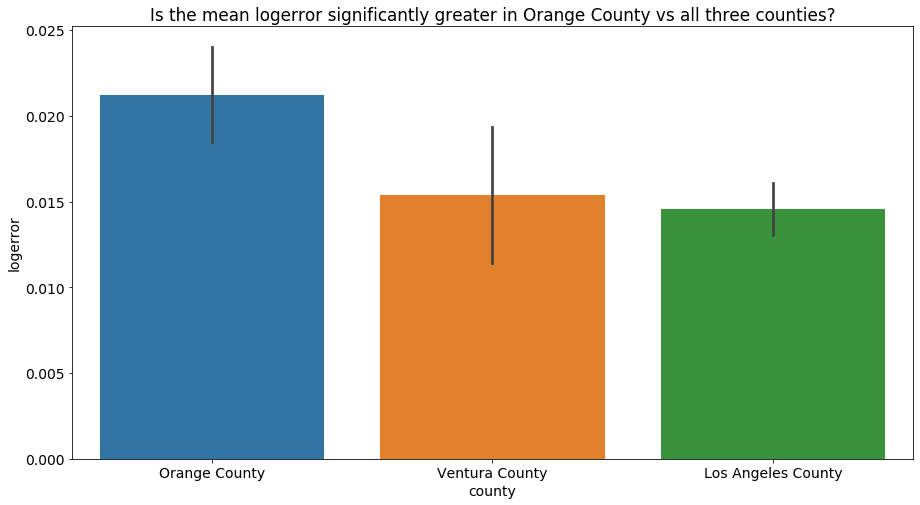

In [29]:
sns.barplot(x=df.county, y=df.logerror)
plt.tight_layout()
plt.title('Is the mean logerror significantly greater in Orange County vs all three counties?')

is mean log error greater in orange county than all three counties?

In [30]:
null = 'mean log error in orange county is less than or equal to the mean log error for all three counties'
alpha = .05

t, p = stats.ttest_1samp(train[train.county == 'Orange County'].logerror, 
                train.logerror.mean())
t, p

(1.8078980709170314, 0.070648735600005)

In [31]:
if p/2 > alpha:
    print("We  fail to reject", null)
elif t < 0:
    print("We fail to reject", null)
else:
    print("We fail to reject", null)

We fail to reject mean log error in orange county is less than or equal to the mean log error for all three counties


**Conclusion: mean log error in orange county is less than or equal to the mean log error for all three counties**

### Clustering

#### Home Value and Square Feet

In [32]:
# scale continuous features
scaler = StandardScaler()

# add scaled versions to dataframe
train_scaled = train.copy()
train_scaled[cont_vars] = scaler.fit_transform(train[cont_vars])

# choose features to cluster on
X = train_scaled[['home_value', 'sqft']]

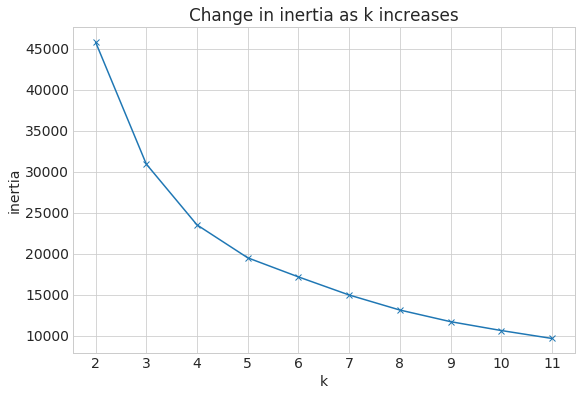

In [33]:
# elbow method to determine k

# inertia using X
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

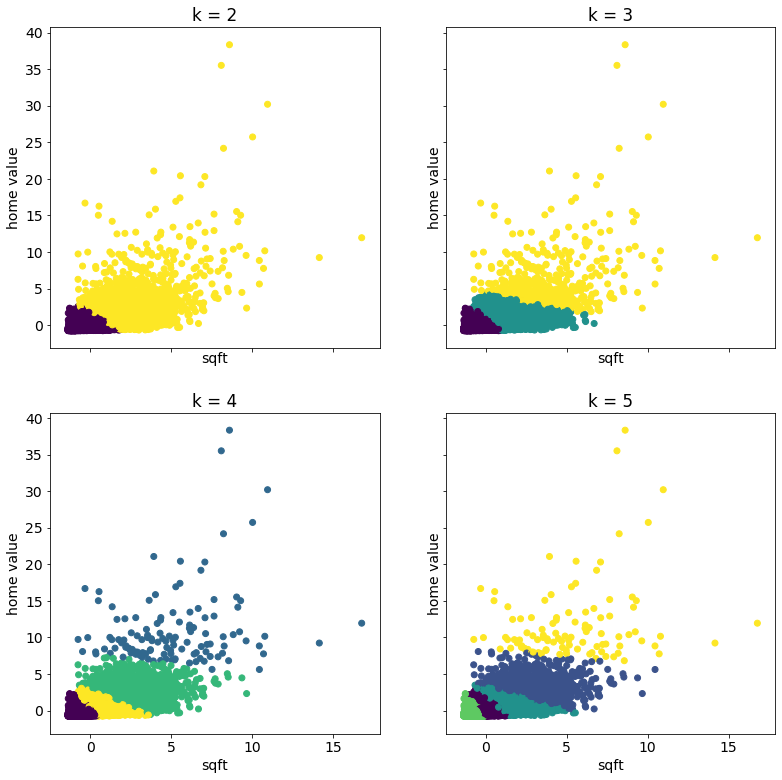

In [34]:
# visually determine k
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.sqft, X.home_value, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sqft', ylabel='home value')

In [35]:
# choose k
kmeans = KMeans(n_clusters=3)

# create and fit model
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
train_scaled['cluster'] = kmeans.labels_

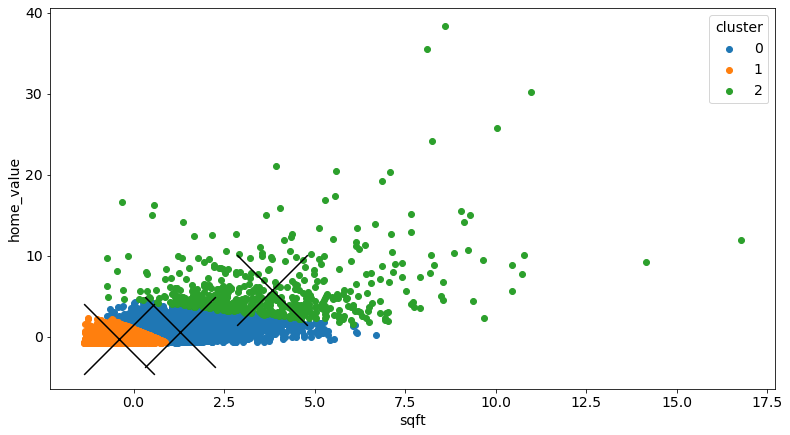

In [37]:
# clusters with centroids
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('cluster'):
    ax.scatter(subset.sqft, subset.home_value, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='Home Value', xlabel='Square Feet')

train_scaled.groupby('cluster').mean().plot.scatter(y='home_value', x='sqft', marker='x', s=5000, ax=ax, c='black')

#### Bedrooms and Bathrooms

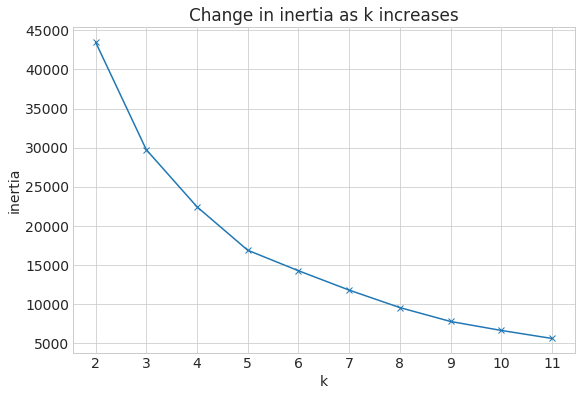

In [38]:
# choose features to cluster on
X2 = train_scaled[['bedroomcnt', 'bathroomcnt']]

# elbow method to determine k
# inertia using X2
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

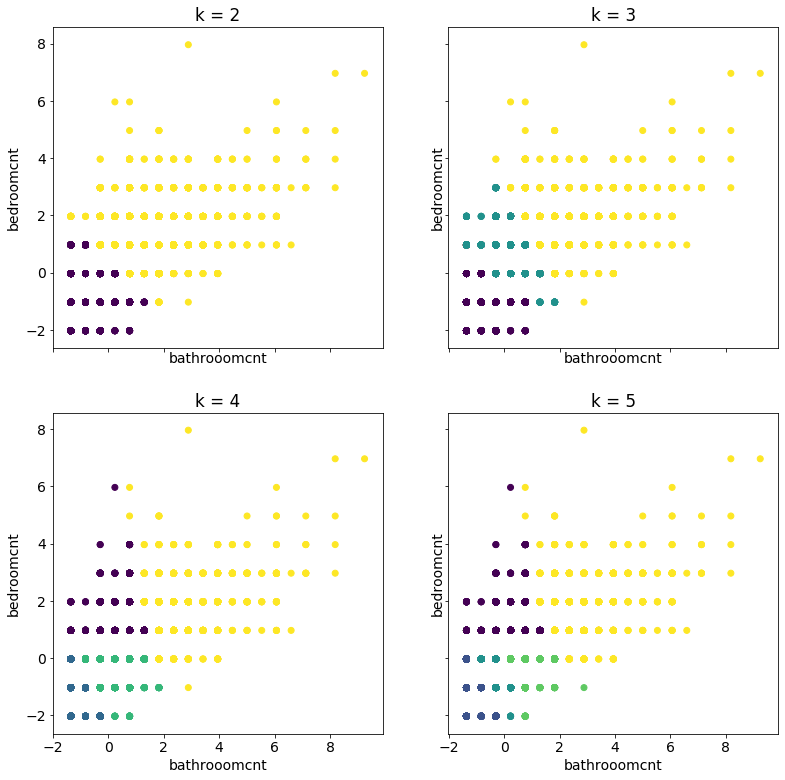

In [39]:
# visually determine k
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X2).predict(X2)
    ax.scatter(X2.bathroomcnt, X2.bedroomcnt, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='bathrooomcnt', ylabel='bedroomcnt')

In [40]:
# choose k
kmeans2 = KMeans(n_clusters=3)

# create and fit model
kmeans2.fit(X2)

train_scaled['room_cluster'] = kmeans2.labels_

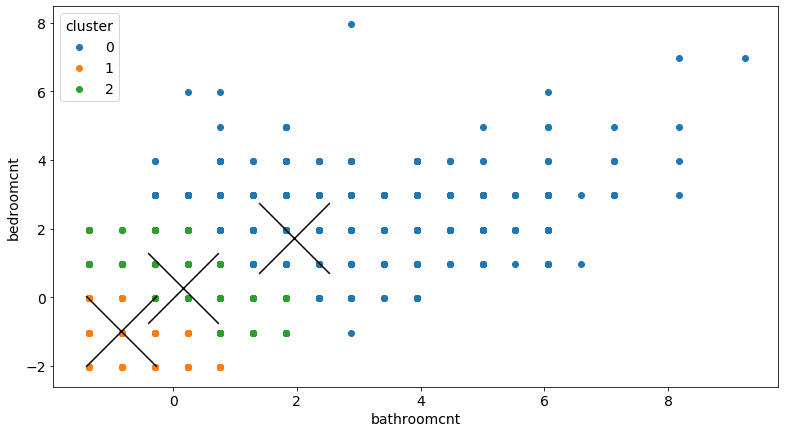

In [41]:
# clusters with centroids
fig, ax = plt.subplots(figsize=(13, 7))

for cluster, subset in train_scaled.groupby('room_cluster'):
    ax.scatter(subset.bathroomcnt, subset.bedroomcnt, label=cluster)
ax.legend(title='cluster')
ax.set(ylabel='bedroomcnt', xlabel='bathroomcnt')

train_scaled.groupby('room_cluster').mean().plot.scatter(y='bedroomcnt', x='bathroomcnt', marker='x', s=5000, ax=ax, c='black')

In [42]:
train_scaled

,bathroomcnt,bedroomcnt,sqft,latitude,longitude,lot_sqft,property_type,zipcode,yearbuilt,structure_value,home_value,land_value,taxamount,transactiondate,logerror,county,cluster,room_cluster
8511,0.232857,-0.027575,0.331397,0.715467,-1.995104,-0.191410,261.0,96351.0,1995.0,1.099512,0.363995,-0.034402,0.251157,2017-02-10,0.006182,Ventura County,1,2
12984,0.762674,0.971376,1.132943,0.745015,-2.008135,-0.172507,261.0,96351.0,2001.0,0.917295,0.256786,-0.092285,0.155873,2017-03-01,0.004454,Ventura County,0,2
30119,-0.296960,-1.026526,-0.874171,-0.866564,0.093728,-0.108131,266.0,96246.0,1976.0,-0.204790,-0.446299,-0.506851,-0.458960,2017-05-02,-0.009073,Los Angeles County,1,1
39086,-0.296960,-0.027575,-0.490729,0.648832,-0.218028,-0.147845,261.0,96321.0,1950.0,-0.689673,-0.665853,-0.571823,-0.702499,2017-05-31,0.054205,Los Angeles County,1,2
12391,0.762674,-1.026526,-0.684617,1.524016,-0.703784,0.779136,266.0,96401.0,1985.0,-0.186022,-0.405636,-0.460757,-0.365149,2017-02-28,-0.021521,Los Angeles County,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,-0.296960,-0.027575,-0.075875,-0.317991,0.399503,-0.174966,261.0,96173.0,2014.0,0.067546,-0.057188,-0.110234,-0.039576,2017-01-04,-0.016904,Los Angeles County,1,2
67464,-1.356594,-0.027575,-0.000053,0.660475,-2.705085,-0.185991,261.0,97104.0,1951.0,-0.297542,-0.435321,-0.447504,-0.459791,2017-08-29,-2.238112,Ventura County,1,1
63879,0.762674,1.970327,0.793911,1.758166,-0.545976,1.377327,261.0,96403.0,1967.0,0.812760,0.352545,0.087581,0.360931,2017-08-17,0.008081,Los Angeles County,0,0
6530,0.762674,-0.027575,0.792828,-1.261538,1.747932,-0.180648,261.0,96989.0,1992.0,0.235462,0.465769,0.517797,0.275779,2017-01-31,-0.017720,Orange County,0,2


## Modeling

In [43]:
# select variables for training models
X_train = train.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])
X_validate = validate.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])
X_test = test.drop(columns=['property_type', 'zipcode', 'transactiondate', 'logerror', 'county'])

# target variable
y_train = train.logerror
y_validate = validate.logerror
y_test = test.logerror

In [44]:
# scale the selected variables
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, 
                                                                 X_validate,
                                                                 X_test)

#### Feature Selection

In [45]:
# reduce to 5 best features using Recursive Feature Elimination
rfe(X_train, y_train, 5)

['bathroomcnt', 'bedroomcnt', 'sqft', 'yearbuilt', 'taxamount']

In [46]:
# use top features of RFE to process with modeling
X_train = train[['bathroomcnt', 'bedroomcnt', 'sqft', 'yearbuilt', 'taxamount']]
X_validate = validate[['bathroomcnt', 'bedroomcnt', 'sqft', 'yearbuilt', 'taxamount']]
X_test = test[['bathroomcnt', 'bedroomcnt', 'sqft', 'yearbuilt', 'taxamount']]

In [47]:
## Conclusion